In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.model_selection import train_test_split

In [3]:
plt.style.use('seaborn')

## Import danych

In [4]:
df = pd.read_csv('rotatingHyperplane.data', sep=' ', header=None)
print(len(df))
df.columns = [f'f{col}' for col in df.columns.values]
df.head()

200000


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763
1,0.275030,0.075388,0.610592,0.954931,0.274069,0.190202,0.001299,0.683527,0.486260,0.487515
2,0.233156,0.889909,0.038327,0.592379,0.655174,0.119839,0.652477,0.984323,0.206738,0.374650
3,0.277937,0.340915,0.265790,0.116670,0.136830,0.546089,0.494619,0.015384,0.358995,0.242478
4,0.254909,0.777916,0.225022,0.983103,0.803619,0.836315,0.163104,0.637497,0.008760,0.631190


In [5]:
labels = pd.read_csv('rotatingHyperplane.labels', sep=' ', header=None)[0]
print(len(labels))
labels.head()

200000


0    0
1    0
2    1
3    0
4    0
Name: 0, dtype: int64

## Pierwsze i ostatnie 10% 

In [6]:
n = len(df)
n_10 = n // 10
df1, df2 = df.loc[:n_10-1, :], df.loc[n-n_10:, :]
labels1, labels2 = labels.loc[:n_10-1], labels.loc[n-n_10:]
print(f'Pierwsze 10% danych: {len(df1)}')
print(f'Pierwsze 10% labeli: {len(labels1)}')
print(f'Ostatnie 10% danych: {len(df2)}')
print(f'Ostatnie 10% labeli: {len(labels2)}')

Pierwsze 10% danych: 20000
Pierwsze 10% labeli: 20000
Ostatnie 10% danych: 20000
Ostatnie 10% labeli: 20000


## Dystrybucja zmiennych (data drift)

(0.0, 1.0, 0.0, 1.0)

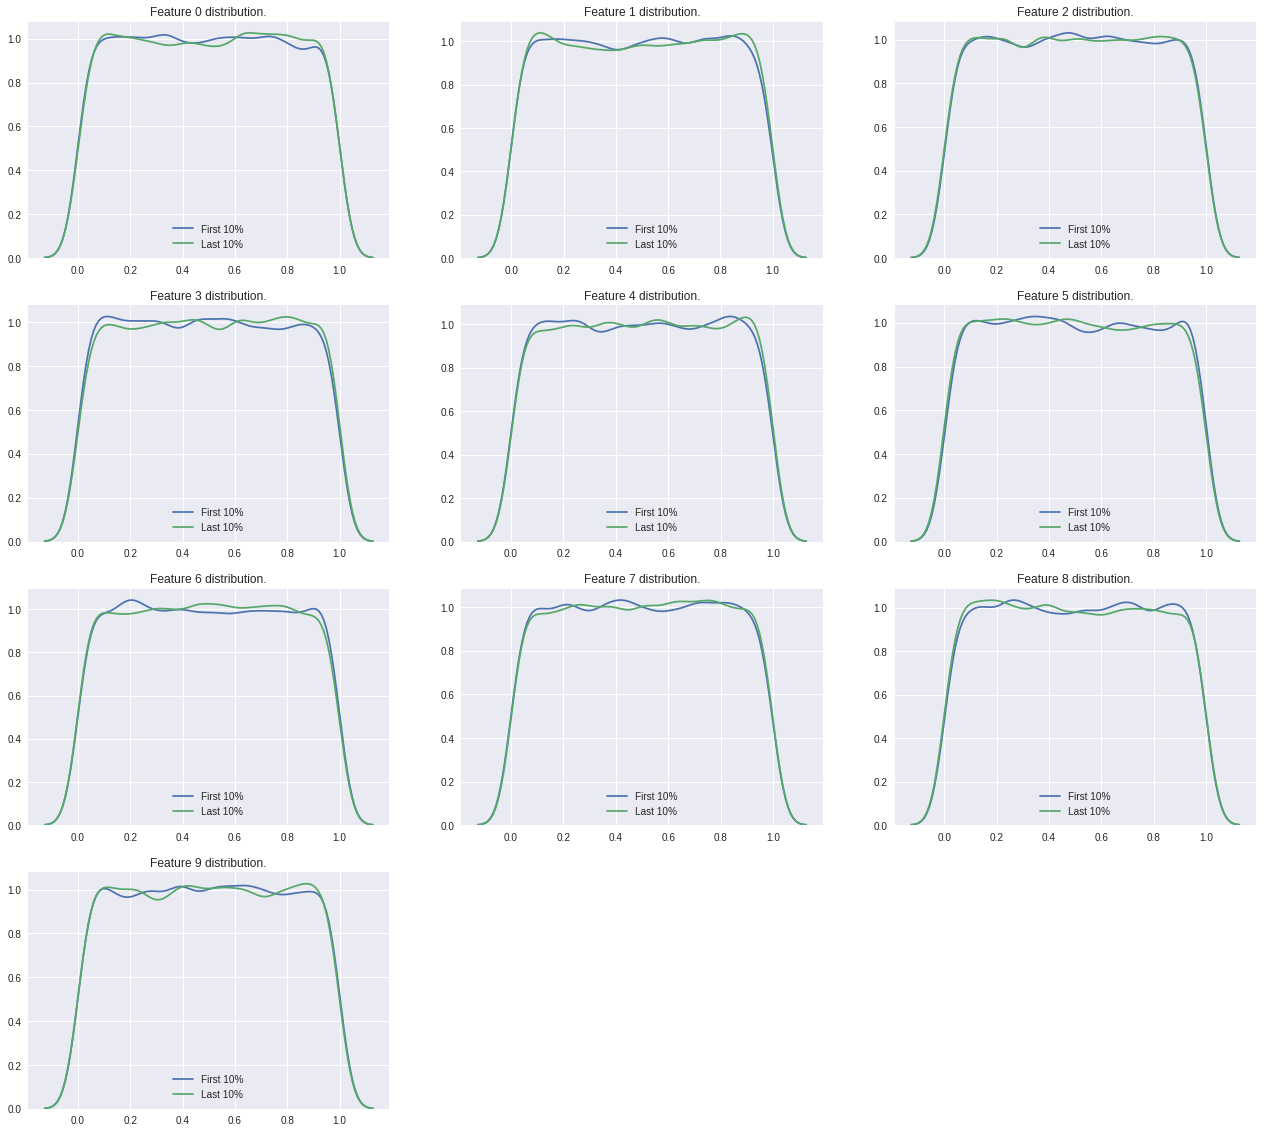

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(22, 20))
for i, col in enumerate(df.columns):
    sns.distplot(df1[col], hist=False, ax=axes[i//3][i%3], label='First 10%')
    sns.distplot(df2[col], hist=False, ax=axes[i//3][i%3], label='Last 10%')
    axes[i//3][i%3].set_title(f'Feature {i} distribution.')
    axes[i//3][i%3].set_xlabel('')
    
axes[3, 1].axis('off')
axes[3, 2].axis('off')

In [8]:
def data_drift(df1, df2, feature):
    both = df1.append(df2)
    feature_col = both[feature]
    _, bins_edges = np.histogram(feature_col, bins=20)

    h1, _ = np.histogram(df1[feature], bins=bins_edges)
    h2, _ = np.histogram(df2[feature], bins=bins_edges)
    h1 = np.array(h1, dtype=np.float64) / len(df1)
    h2 = np.array(h2, dtype=np.float64) / len(df2)
    diff = 1 - np.sum(np.min(np.array([h1, h2]), axis=0))
    return diff


data_drifts = []
for f in df.columns:
    f_data_drift = data_drift(df1, df2, f)
    data_drifts.append(f_data_drift)
    print(f'Data drift dla zmniennej {f}: {np.round(f_data_drift, 4)}')
print(f'Najwyższa wartość dla {df.columns[np.argmax(data_drifts)]} = {np.round(np.max(data_drifts), 4)}')

Data drift dla zmniennej f0: 0.0157
Data drift dla zmniennej f1: 0.0174
Data drift dla zmniennej f2: 0.0146
Data drift dla zmniennej f3: 0.0206
Data drift dla zmniennej f4: 0.0193
Data drift dla zmniennej f5: 0.0205
Data drift dla zmniennej f6: 0.0177
Data drift dla zmniennej f7: 0.0157
Data drift dla zmniennej f8: 0.0183
Data drift dla zmniennej f9: 0.0169
Najwyższa wartość dla f3 = 0.0206


Dla obu podzbiorów danych narysowane zostały rozkłady każdej z 10 zmiennych. Jak widać na wykresach wszystkie zmienne dla obu grup mają podobną dystrybucję z nieznacznymi fluktuacjami. Podobieństwo między grupami potwierdza również wyniki liczbowe opisujące różnice między histogramami. Wszystkie rozkłady różnią się między grupami o podobną wartość, gdzie maksimum wynosi 0.0206 (0 oznacza identyczny rozkład, a 1 całkowitą rozbieżność).

Wartości >1 i <0 nie występują w danych, a ich występowanie na wykresie wynika z wygładzania funkcji.    


## Dystrybucja reszt (residual drift)
Model jest trenowany na 80% danych z pierwszego zbioru, a reszty wyliczane dla 2 grup
* 20% pierwszego zbioru (pierwsze 10% danych) - zbiór A
* cały drugi zbiór (ostatnie 10% danych) - zbiór B

In [9]:
train_df, test_df, train_labels, test_labels = train_test_split(df1, labels1)
model = LogisticRegression(solver='lbfgs')
model.fit(train_df, train_labels)
res1 = model.predict_proba(test_df)[:, 1] - test_labels
res2 = model.predict_proba(df2)[:, 1] - labels2

Text(0.5, 0, 'Reszta')

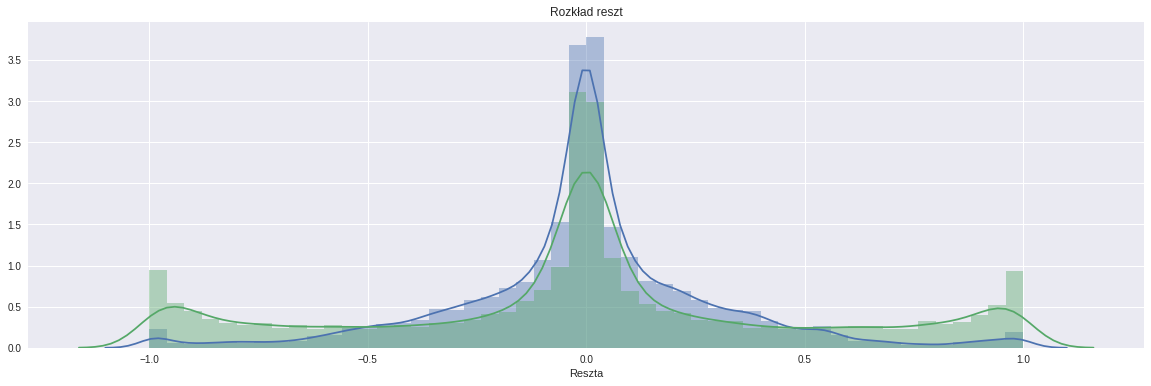

In [10]:
plt.figure(figsize=(20, 6))
sns.distplot(res1, label='Zbiór A')
sns.distplot(res2, label='Zbiór B')
plt.title('Rozkład reszt')
plt.xlabel('Reszta')

In [11]:
def residuals_drift(res1, res2):
    both = np.hstack([res2, res1])
    _, bins_edges = np.histogram(both, bins=20)

    h1, _ = np.histogram(res1, bins=bins_edges)
    h2, _ = np.histogram(res2, bins=bins_edges)
    h1 = np.array(h1, dtype=np.float64) / len(res1)
    h2 = np.array(h2, dtype=np.float64) / len(res2)
    diff = 1 - np.sum(np.min(np.array([h1, h2]), axis=0))
    return diff

print(f'Residuals drift: {np.round(residuals_drift(res1, res2), 4)}')

Residuals drift: 0.2483


Na przykładzie reszt można zauważyć wyraźną różnicę między obiema grupami danych. Widać, że dla danych testowych z pierwszych 10% (zbiór A) przeważająca część rozkładu reszt skupiona jest w okolicach 0, natomiast dla zbioru B (ostatnich 10%) rozkład reszt zaczyna gromadzić się w ogonach przy maksymalnych możliwych błędach. Wartość odchylenia histogramów wynosi 0.2483 co potwierdza dość wyraźną różnicę. Można stąd wnioskować, że dane testowe A są bardziej zbliżone (zapewne czasowo) do danych treningowych niż ostatnie 10%, dla których model znacznie pogarsza swoje działanie.

## Concept drift
Tworzone są dwa modele XGBoost. Jeden trenowany na pierwszych 10% danych, drugi na ostatnich 10%. Dla obu wyliczone i porównane są wartości PDP. 

In [12]:
bmodel1 = xgb.sklearn.XGBClassifier()
bmodel2 = xgb.sklearn.XGBClassifier()
bmodel1.fit(df1, labels1)
bmodel2.fit(df2, labels2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

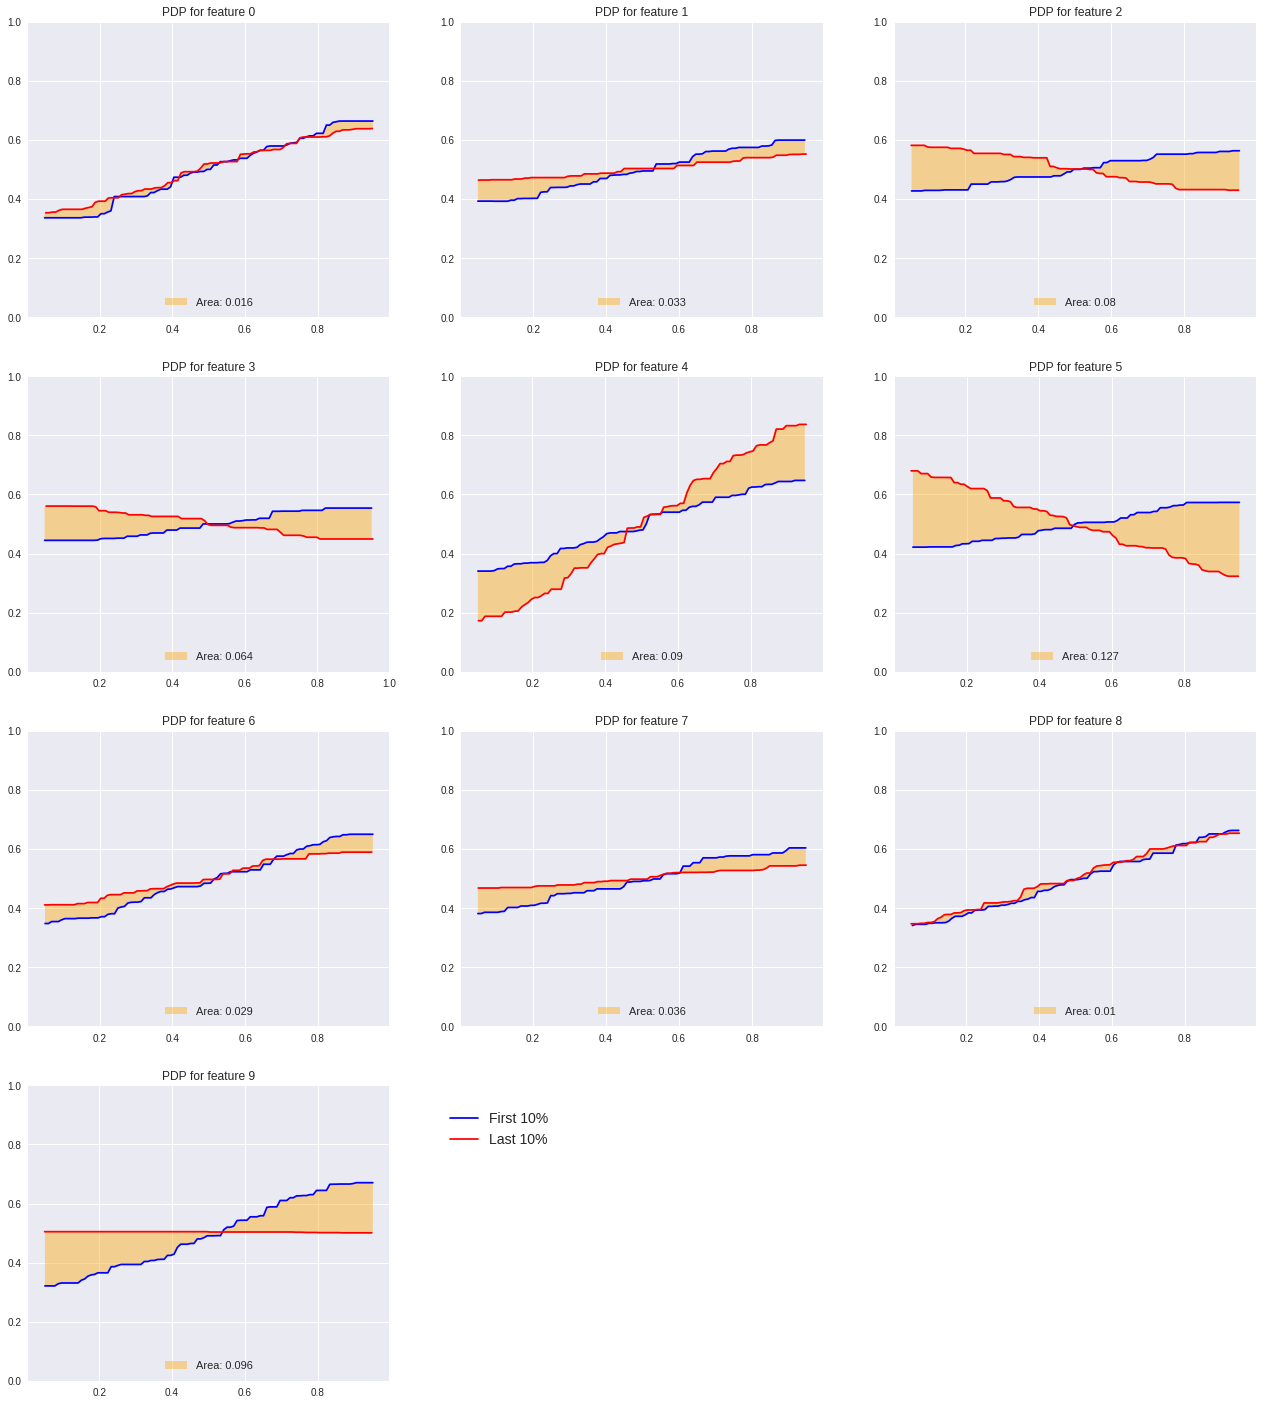

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3)
fig.set_figheight(25)
fig.set_figwidth(22)

for i in range(len(df.columns)):
    pdv1 = partial_dependence(bmodel1, df1, features=[i])
    vals1, xs1 = pdv1[0].flatten(), pdv1[1][0]
    pdv2 = partial_dependence(bmodel2, df2, features=[i])
    vals2, xs2 = pdv2[0].flatten(), pdv2[1][0]
    mins, maxes = np.minimum(vals1, vals2), np.maximum(vals1, vals2)
    area = np.round(np.trapz(maxes, xs1) - np.trapz(mins, xs1), 3)
    l1 = axes[i//3, i%3].plot(xs1, vals1, color='b')[0]
    l2 = axes[i//3, i%3].plot(xs2, vals2, color='r')[0]
    axes[i//3, i%3].fill_between(xs1, vals1, vals2, facecolor='orange', alpha=0.4, label=f'Area: {area}')
    axes[i//3, i%3].set_title(f'PDP for feature {i}')
    axes[i//3, i%3].legend(loc='lower center', fontsize=11)
    axes[i//3, i%3].set_ylim((0, 1))
    
axes[3, 1].axis('off')
axes[3, 2].axis('off')
plt.figlegend(handles=(l1, l2), labels=('First 10%', 'Last 10%'), loc=(0.35, 0.18), fontsize=14)
    

Porównanie wykresów PDP dla obu modeli pokazuje, że niektóre zmienne zmieniły swój wpływ na predykcje. Przykładowo dla zmiennych 0 i 8 zmiana jest minimalna, a wykresy wyglądają prawie identycznie. Natomiast dla zmiennych takich jak 5 i 9 różnice między wykresami są nawet 10 razy większe niż dla wymienionych wcześniej zmiennych. Dla zmiennej 5 widoczne jest też odwrócenie trendu, gdzie wcześniej większa wartość zmiennej mogła powodować wzrost wartości predykcji teraz powoduje jej spadek.

## Podsumowanie
Na podstawie powyższych eksperymentów można stwierdzić, że dane w zbiorze są rozłożone czasowo, a modele trenowane na początkowych danych z czasem tracą na skuteczności. Dane pozostają rozdystrybuowane w ten sam sposób jednak ich wpływ na predykcje się zmienia. Świadczą o tym wysokie wartości reszt dla późniejszych danych oraz zmiany we wpływie niektórych zmiennych na wartość predykcji.